In [ ]:
!pip install tensorflow scikit-learn matplotlib pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping callback

warnings.filterwarnings("ignore")
K.clear_session()

Cell 1

In [ ]:
# Load the dataset
df = pd.read_csv('/content/theft_data.csv')  # Replace with '/content/theft_data.csv' in Colab

# Convert dates and sort
df['dates'] = pd.to_datetime(df['dates'], format='%d-%m-%Y')
df = df.sort_values(by=['idmeter', 'dates'])
print("Dataset loaded and preprocessed:")
print(df.head())
print(df.info())

# Identify 15-minute interval columns
time_cols = [col for col in df.columns if re.match(r'^\d{1,2}:\d{2}$', col)]
assert len(time_cols) == 96, f"Expected 96 time columns, found {len(time_cols)}"
# Check label
if 'Label' not in df.columns:
    raise ValueError("Missing 'Label' column")

Dataset loaded and preprocessed:
       Unnamed: 0       idmeter      dates  00:00  00:15  00:30  00:45  \
10907           0  KOL-22812986 2019-12-01  0.002  0.003  0.002  0.002   
10908           1  KOL-22812986 2019-12-02  0.002  0.002  0.002  0.002   
10909           2  KOL-22812986 2019-12-03  0.002  0.002  0.002  0.003   
10910           3  KOL-22812986 2019-12-04  0.002  0.003  0.002  0.002   
10911           4  KOL-22812986 2019-12-05  0.002  0.002  0.002  0.002   

        01:00  01:15  01:30  ...  21:45  22:00  22:15  22:30  22:45  23:00  \
10907  0.0020  0.003  0.002  ...  0.009  0.009  0.008  0.010  0.009  0.009   
10908  0.0025  0.002  0.002  ...  0.009  0.009  0.009  0.009  0.008  0.009   
10909  0.0020  0.003  0.002  ...  0.009  0.009  0.009  0.009  0.009  0.009   
10910  0.0020  0.002  0.002  ...  0.009  0.009  0.009  0.009  0.009  0.009   
10911  0.0020  0.002  0.003  ...  0.009  0.009  0.009  0.009  0.009  0.009   

       23:15  23:30  23:45  Label  
10907  0.006  0.0

Cell 3

In [ ]:
# Prepare sequence data
X_data, y_data = [], []
window_size = 7

for idmeter, group in df.groupby('idmeter'):
    if len(group) < window_size:
        continue

    consumption = group[time_cols].values
    labels = group['Label'].values

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(consumption)

    for i in range(window_size, len(scaled)):
        X_data.append(scaled[i - window_size:i])
        y_data.append(labels[i])

X_data = np.array(X_data)
y_data = np.array(y_data)

Cell 4

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, shuffle=False
)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15927, 7, 96)
Shape of X_test: (3982, 7, 96)
Shape of y_train: (15927,)
Shape of y_test: (3982,)


cell 5

In [ ]:
# Class weights for imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.5996611445783132), 1: np.float64(3.0085001888930867)}


Cell 6

In [ ]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x = layers.Dropout(dropout)(x_ff)
    x = layers.LayerNormalization(epsilon=1e-6)(x + x_ff)

    return x

Cell 7

In [ ]:
# Build Transformer Model
def build_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model = build_transformer_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 7, 96)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 96)     │     99,168 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 7, 96)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 7, 96)     │          0 │ dropout_9[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 96)     │        192 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 7, 128)    │     12,416 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 7, 96)     │     12,384 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 7, 96)     │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 7, 96)     │          0 │ dropout_10[0][0], │
│                     │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 96)     │        192 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 96)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      6,208 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 130,625 (510.25 KB)

 Trainable params: 130,625 (510.25 KB)

 Non-trainable params: 0 (0.00 B)

cell 8

In [ ]:
# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=2,
    callbacks=[early_stopping]
)
print("Model training complete.")

Epoch 1/50
448/448 - 16s - 35ms/step - accuracy: 0.5100 - loss: 0.6958 - val_accuracy: 0.7301 - val_loss: 0.5593
Epoch 2/50
448/448 - 20s - 45ms/step - accuracy: 0.5613 - loss: 0.6745 - val_accuracy: 0.6001 - val_loss: 0.6205
Epoch 3/50
448/448 - 9s - 21ms/step - accuracy: 0.5651 - loss: 0.6630 - val_accuracy: 0.7684 - val_loss: 0.5865
Epoch 4/50
448/448 - 10s - 23ms/step - accuracy: 0.5647 - loss: 0.6517 - val_accuracy: 0.4928 - val_loss: 0.7109
Epoch 5/50
448/448 - 11s - 24ms/step - accuracy: 0.5936 - loss: 0.6408 - val_accuracy: 0.7207 - val_loss: 0.5687
Epoch 6/50
448/448 - 11s - 24ms/step - accuracy: 0.6276 - loss: 0.6300 - val_accuracy: 0.5957 - val_loss: 0.6527
Epoch 7/50
448/448 - 10s - 22ms/step - accuracy: 0.6446 - loss: 0.6217 - val_accuracy: 0.7539 - val_loss: 0.5747
Epoch 8/50
448/448 - 8s - 19ms/step - accuracy: 0.6498 - loss: 0.6150 - val_accuracy: 0.7564 - val_loss: 0.5719
Epoch 9/50
448/448 - 12s - 27ms/step - accuracy: 0.6677 - loss: 0.6037 - val_accuracy: 0.7589 - va

Cell 9

In [ ]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7022 - loss: 0.5849
Test Loss: 0.5821
Test Accuracy: 0.7250


cell 10

In [ ]:
# Threshold evaluation
y_probs = model.predict(X_test).flatten()
for threshold in [0.8, 0.75, 0.7, 0.6, 0.5, 0.4]:
    y_pred = (y_probs > threshold).astype(int)
    print(f"\n--- Threshold = {threshold} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

--- Threshold = 0.8 ---
Confusion Matrix:
 [[3283    0]
 [ 699    0]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8245    1.0000    0.9038      3283
           1     0.0000    0.0000    0.0000       699

    accuracy                         0.8245      3982
   macro avg     0.4122    0.5000    0.4519      3982
weighted avg     0.6797    0.8245    0.7451      3982


--- Threshold = 0.75 ---
Confusion Matrix:
 [[3283    0]
 [ 699    0]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8245    1.0000    0.9038      3283
           1     0.0000    0.0000    0.0000       699

    accuracy                         0.8245      3982
   macro avg     0.4122    0.5000    0.4519      3982
weighted avg     0.6797    0.8245    0.7451      3982


--- Threshold = 0.7 ---
Confusion Matrix:
 [[3278    5]
 [ 693    6]]
Classification Report:
               preci

cell 11

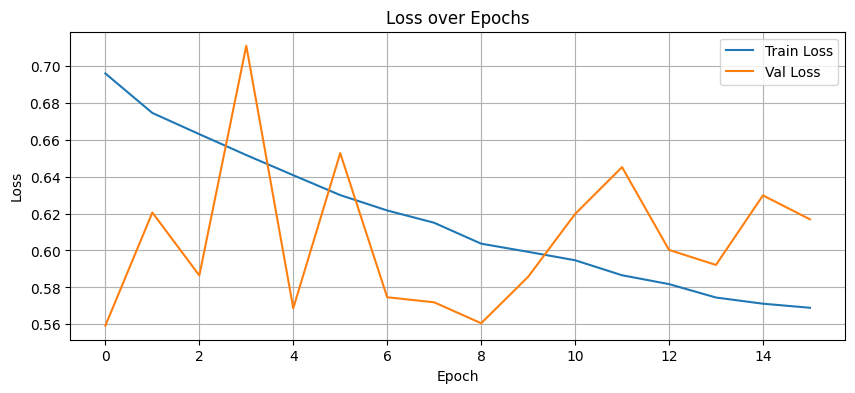

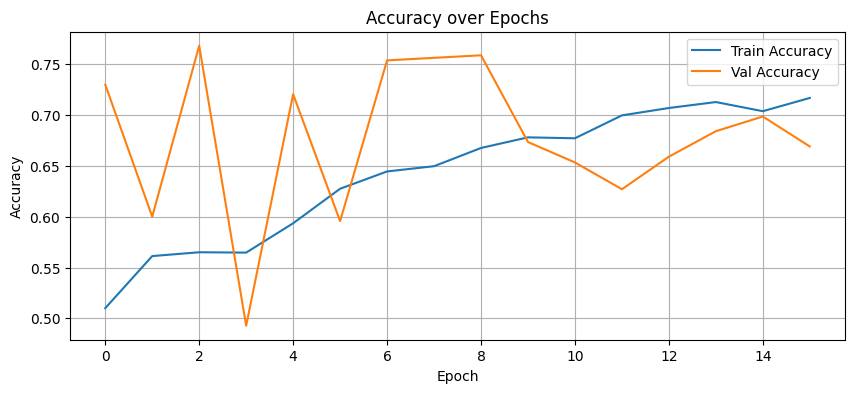

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install lime
from lime.lime_tabular import LimeTabularExplainer

# Step 1: Flatten data for LIME
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a0f5bc99d9e9da64bafa6900ef512b444fbb081d65732e0c95a7599eff722330
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Step 2: Define prediction function for LIME (returns probabilities)
def predict_fn_lime(flattened_data):
    reshaped = flattened_data.reshape(-1, 7, 96)  # reshape back to original shape
    return np.concatenate([(1 - model.predict(reshaped)), model.predict(reshaped)], axis=1)

# Step 3: Feature names for LIME (optional but helpful)
time_steps = [f"Day{i+1}" for i in range(7)]
time_slots = [col for col in time_cols]
feature_names = [f"{day}_{slot}" for day in time_steps for slot in time_slots]

In [ ]:
# Step 4: Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names,
    class_names=["Non-Theft", "Theft"],
    discretize_continuous=True,
    mode="classification"
)

In [ ]:
# Step 5: Explain an instance (choose index)
idx = 0  # pick any test sample index
explanation = explainer.explain_instance(
    X_test_flat[idx],
    predict_fn_lime,
    num_features=10,
    top_labels=1
)

# Step 6: Show explanation
explanation.show_in_notebook(show_table=True, show_all=False)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
